# MENuS
## Using Machine Learning to select the best solver
* Calculate the labels
* Include the ingredients generator.
    * Generate an Instance of Ingredients list.
* Finish the model.
* Use minizinc from python.
    * Run it with 3 Algorithms.
    * Add the Instance to the Instances List.
    * Add the time it takes for each Algorithm to the Time Execution Matrix.
    * Transform the Instances List into the Features Array.
    * Travel through the Time Execution Matrix and pick the Algorithms with faster results for each Instance.
    * The Algorithm with the fastest result will be added to the Labels list.

|  | Alg1 | Alg2 | Alg3 |
| --- | --- | --- | --- |
| Ins1 | X | Y | Z |
| Ins2 | X | Y | Z |
| Ins3 | X | Y | Z |
   
* Transform the ingredients list into the dataset for machine learning.
    * Create the Ingredients list.
    * Test with the minizinc model, all the Alg = 3 -> minizinc(300).
    * Take and transform the one that takes less time.
* Training the AI. Split dataset, 70% for training and 30% for prediction, at least 80% accuracy expected. 
----------------------------------------------------------------------------------------------------------

### Auxiliar Functions

In [208]:
def print_red(text):
    print('\x1b[31m' + text + '\x1b[0m')
    
def print_yellow(text):
    print('\x1b[33m' + text + '\x1b[0m')

def print_green(text):
    print('\x1b[32m' + text + '\x1b[0m')

def print_pink(text):
    print('\x1b[35m' + text + '\x1b[0m')

def print_cyan(text):
    print('\x1b[36m' + text + '\x1b[0m')

## Get the Instances
The instances have been generated using the notebook: Generate Instance.ipynb

In [209]:
import os

instances_folder = '../datasets/100_1_1500'
instances_path = [os.path.join(instances_folder, f) for f in os.listdir(instances_folder) if f.endswith('.dzn')]
instances = []
labels_txt = ''
for path in instances_path:
    with open(path, encoding="utf8") as file_object:
        instances.append(file_object.read())
        
with open(instances_folder+'/labels.txt', encoding="utf8") as file_object:
        labels_txt = file_object.read()
#print(instances_path)
print(labels_txt)

[1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1]


# Machine Learning
## Get data: Parse instances to features.

In [210]:
import numpy as np
import math

# Ingredients list
def get_groceries(g_array):
    data_groceries = []
    for i in range(0, len(g_array)):
        loop_groceries = g_array[i].split("groceries = [|")
        loop_groceries = loop_groceries[1].split("|];\nrequirements")
        loop_groceries = loop_groceries[0].split("|")
        
        for j in range(0, len(loop_groceries)):
            # Conversion from String to Int Array.
            loop_groceries[j] = [int(x) for x in loop_groceries[j].split(",")]
            
        data_groceries = data_groceries + [np.array(loop_groceries)]
    return data_groceries

def get_budget(array):
    data_budget = []
    for i in range(0, len(array)):
        loop_budget = array[i].split("budget = ")
        loop_budget = loop_budget[1].split(";")
            
        data_budget = data_budget + [int(loop_budget[0])]
    return data_budget

def get_variety(array):
    data_var = []
    for i in range(0, len(array)):
        loop_var = array[i].split("variety = ")
        loop_var = loop_var[1].split(";")
            
        data_var = data_var + [int(loop_var[0])]
    return data_var

def get_requirements(r_array):
    data_requirements = []
    for i in range(0, len(r_array)):
        loop_requirements = r_array[i].split("requirements = [|")
        loop_requirements = loop_requirements[1].split("|];")
        loop_requirements = loop_requirements[0].split("|")
        
        for j in range(0, len(loop_requirements)):
            # Conversion from String to Int Array.
            loop_requirements[j] = [int(x) for x in loop_requirements[j].split(",")]
            
        data_requirements = data_requirements + [np.array(loop_requirements)]
    return data_requirements


def create_features(instances):
    res = []
    np_groceries = get_groceries(instances)
    np_requirements = get_requirements(instances)
    np_budget = get_budget(instances)
    variety = get_variety(instances)
    
    for i in range(0,len(instances)):
        # features: i in the left represents an Instance; 0,1... in the right represents a Feature.
        #----------------------------------------------------
        # np_groceries: i in the left represents an Instance; ":" represents all rows; 0,1... in the right represents a Macronutrient Column.
        # 0: Calories. 1: Protein. 2: Carbo. 3: Fat. 4: Quantity. 5: Price.
        #----------------------------------------------------
        """
                    "mean_calories": np.mean(np_groceries[i][:,0]),
                    "median_calories": np.median(np_groceries[i][:,0]),
                    "std_calories": np.std(np_groceries[i][:,0]),
                    "var_calories": np.var(np_groceries[i][:,0]),
                    "min_calories": np.min(np_groceries[i][:,0]),
                    "max_calories": np.max(np_groceries[i][:,0]),
                    "argmin_calories": np.argmin(np_groceries[i][:,0]),
                    "argmax_calories": np.argmax(np_groceries[i][:,0]),
                    "q1_calories": np.percentile(np_groceries[i][:,0],25),
                    "q3_calories": np.percentile(np_groceries[i][:,0],75),
                    "n_ingredients": len(np_groceries[i]),
                    "budget" : np_budget[i],
                    "req_min_cal" : np_requirements[i][0][0],
                    "req_max_cal" : np_requirements[i][0][1],     

                    Before Valentina
                    "var_calories": math.ceil(np.var(4*np_groceries[i][:,0])+np.var(4*np_groceries[i][:,1])+np.var(9*np_groceries[i][:,2])),
                    "min_calories": math.ceil(np.min(4*np_groceries[i][:,0])+np.min(4*np_groceries[i][:,1])+np.min(9*np_groceries[i][:,2])),
                    "argmin_calories": math.ceil(np.argmin(4*np_groceries[i][:,0])+np.argmin(4*np_groceries[i][:,1])+np.argmin(9*np_groceries[i][:,2])),
                    "req_min_cal" : np_requirements[i][0][0],
                    "budget" : np_budget[i],  
                    "variety" : variety[i]  
        """
        res.append({
                    
                    "n_ingredients": len(np_groceries[i]),
                    "budget" : np_budget[i],
                    "variety" : variety[i]
                    })
    return res

## Create Labels and Features.
Represents the solver that solved the model in the best way, comparing first the result and then the time. The best solver will be the one that solves the model with a minor value in less time.

In [211]:
import pandas as pd
features = pd.DataFrame(create_features(instances))
print('Features:')
print(features.head())

import ast
labels = ast.literal_eval(labels_txt)
print('\nLabels:')
print(labels[0:5])

Features:
   n_ingredients  budget  variety
0            153  250000       39
1            718  250000        7
2            153  250000        1
3            971  250000       11
4           1199  250000       10

Labels:
[1, 0, 1, 0, 0]


## Algorithms

In [212]:
X = features # Features
y = labels # Labels

# Normalize the data to have zero mean and unit variance
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = np.where(std == 0, 0, (X - mean) / std)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
from pprint import pprint

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
#pprint(random_grid)


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
###rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
###rf_random.fit(X_train, y_train)

In [213]:
# rf_random.best_params_

def evaluate(model, test_features, test_labels):
    y_pred = model.predict(test_features)
    errors = abs(y_pred - test_labels)
    accuracy = model.score(test_features, test_labels)
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print_green('Accuracy = {:0.2f}%.'.format(accuracy*100))
    
    return accuracy, y_pred

base_model = RandomForestClassifier(n_estimators = 10, random_state = 0)
base_model.fit(X_train, y_train)
base_accuracy, base_pred = evaluate(base_model, X_test, y_test)

###best_random = rf_random.best_estimator_
###random_accuracy, random_pred = evaluate(best_random, X_test, y_test)

###print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


Model Performance
Average Error: 0.3500 degrees.
Accuracy = 65.00%.


In [214]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
###grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
###grid_search.fit(X_train, y_train)
###grid_search.best_params_

In [215]:
###best_grid = grid_search.best_estimator_
###grid_accuracy, grid_pred = evaluate(best_grid, X_test, y_test)

###print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

## Confusion Matrix

[[12  2]
 [ 5  1]]


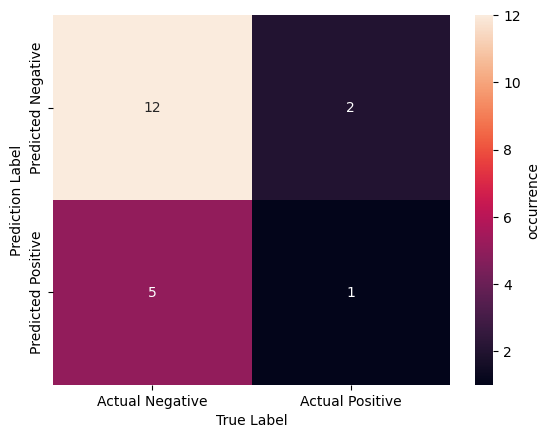

In [216]:
from sklearn.metrics import confusion_matrix
# create confusion matrix
cm = confusion_matrix(y_test, grid_pred)
# print confusion matrix
print(cm)
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cbar_kws={"orientation": "vertical", "label": "occurrence"}, xticklabels=['Actual Negative', 'Actual Positive'], yticklabels=['Predicted Negative', 'Predicted Positive'])
plt.xlabel('True Label')
plt.ylabel('Prediction Label')
plt.show()

In [217]:
unique, counts = np.unique(y_train, return_counts=True)
print(unique)
print(counts)


[0 1]
[49 31]


In [218]:
freq = {}

# Count frequency of each element in the array
for num in labels:
    if num in freq:
        freq[num] += 1
    else:
        freq[num] = 1

# Print frequency of each element
for num, count in freq.items():
    print(f"{num}: {count} {count/len(labels)*100}%")


1: 37 37.0%
0: 63 63.0%


<AxesSubplot:>

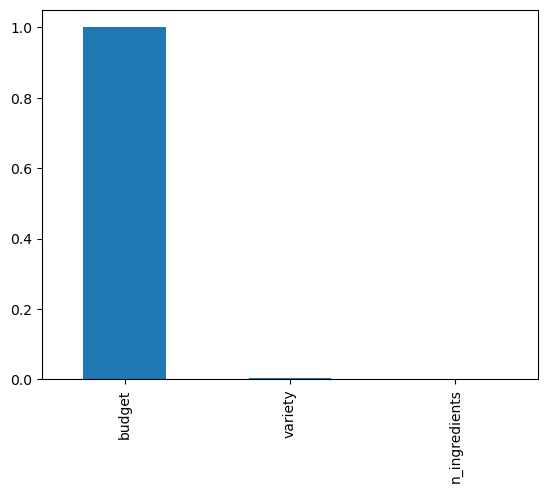

In [219]:
from sklearn.feature_selection import chi2

chi_scores = chi2(features,labels)

p_values = pd.Series(chi_scores[1],index = features.columns)
p_values.sort_values(ascending = False , inplace = True)

p_values.plot.bar()

<AxesSubplot:>

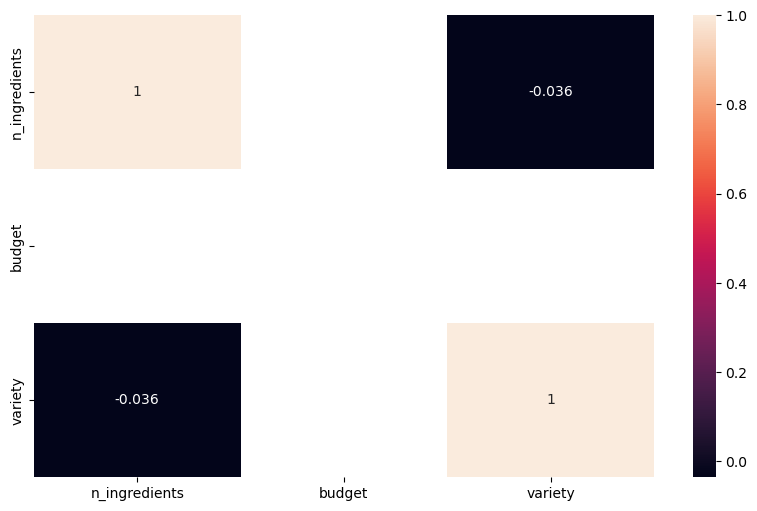

In [220]:
# Correlation Matrix
cor = features.corr()

# Heatmap
plt.figure(figsize = (10,6))
sns.heatmap(cor,annot = True)
           